<a href="https://colab.research.google.com/github/Auvarmf/Riset-MBKM-CNN2023/blob/main/Modelv2_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tqdm import tqdm
import shutil
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import concatenate
from google.colab import drive

In [32]:
# Mount Google Drive to access files and folders
drive.mount('/content/MBKMCNN')

Drive already mounted at /content/MBKMCNN; to attempt to forcibly remount, call drive.mount("/content/MBKMCNN", force_remount=True).


In [33]:
# Define the base directory where all images are stored
BASE_DIR = '/content/MBKMCNN/MyDrive/MBKMCNN/datasetv2_inception'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'validation')

class_names = os.listdir(train_dir)

class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

IMG_SIZE = (32, 32)

In [34]:
def load_data(directory):
    images = []
    labels = []

    for folder in os.listdir(directory):
        if folder in class_names:
            label = class_names.index(folder)

            for file in os.listdir(os.path.join(directory, folder)):
                img_path = os.path.join(os.path.join(directory, folder), file)

                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    image = cv2.imread(img_path)

                    if image is not None:
                        image = cv2.resize(image, IMG_SIZE)
                        images.append(image)
                        labels.append(label)

    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int32")

    # Shuffle the data using sklearn.utils.shuffle
    images, labels = shuffle(images, labels, random_state=25)

    return images, labels

In [35]:
train_images, train_labels = load_data(train_dir)

In [36]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [37]:
def display_examples(class_names, images, labels):
    figsize = (20, 20)
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Contoh Sampel Dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].astype(np.uint8))
        plt.xlabel(class_names[labels[i]])
    plt.show()

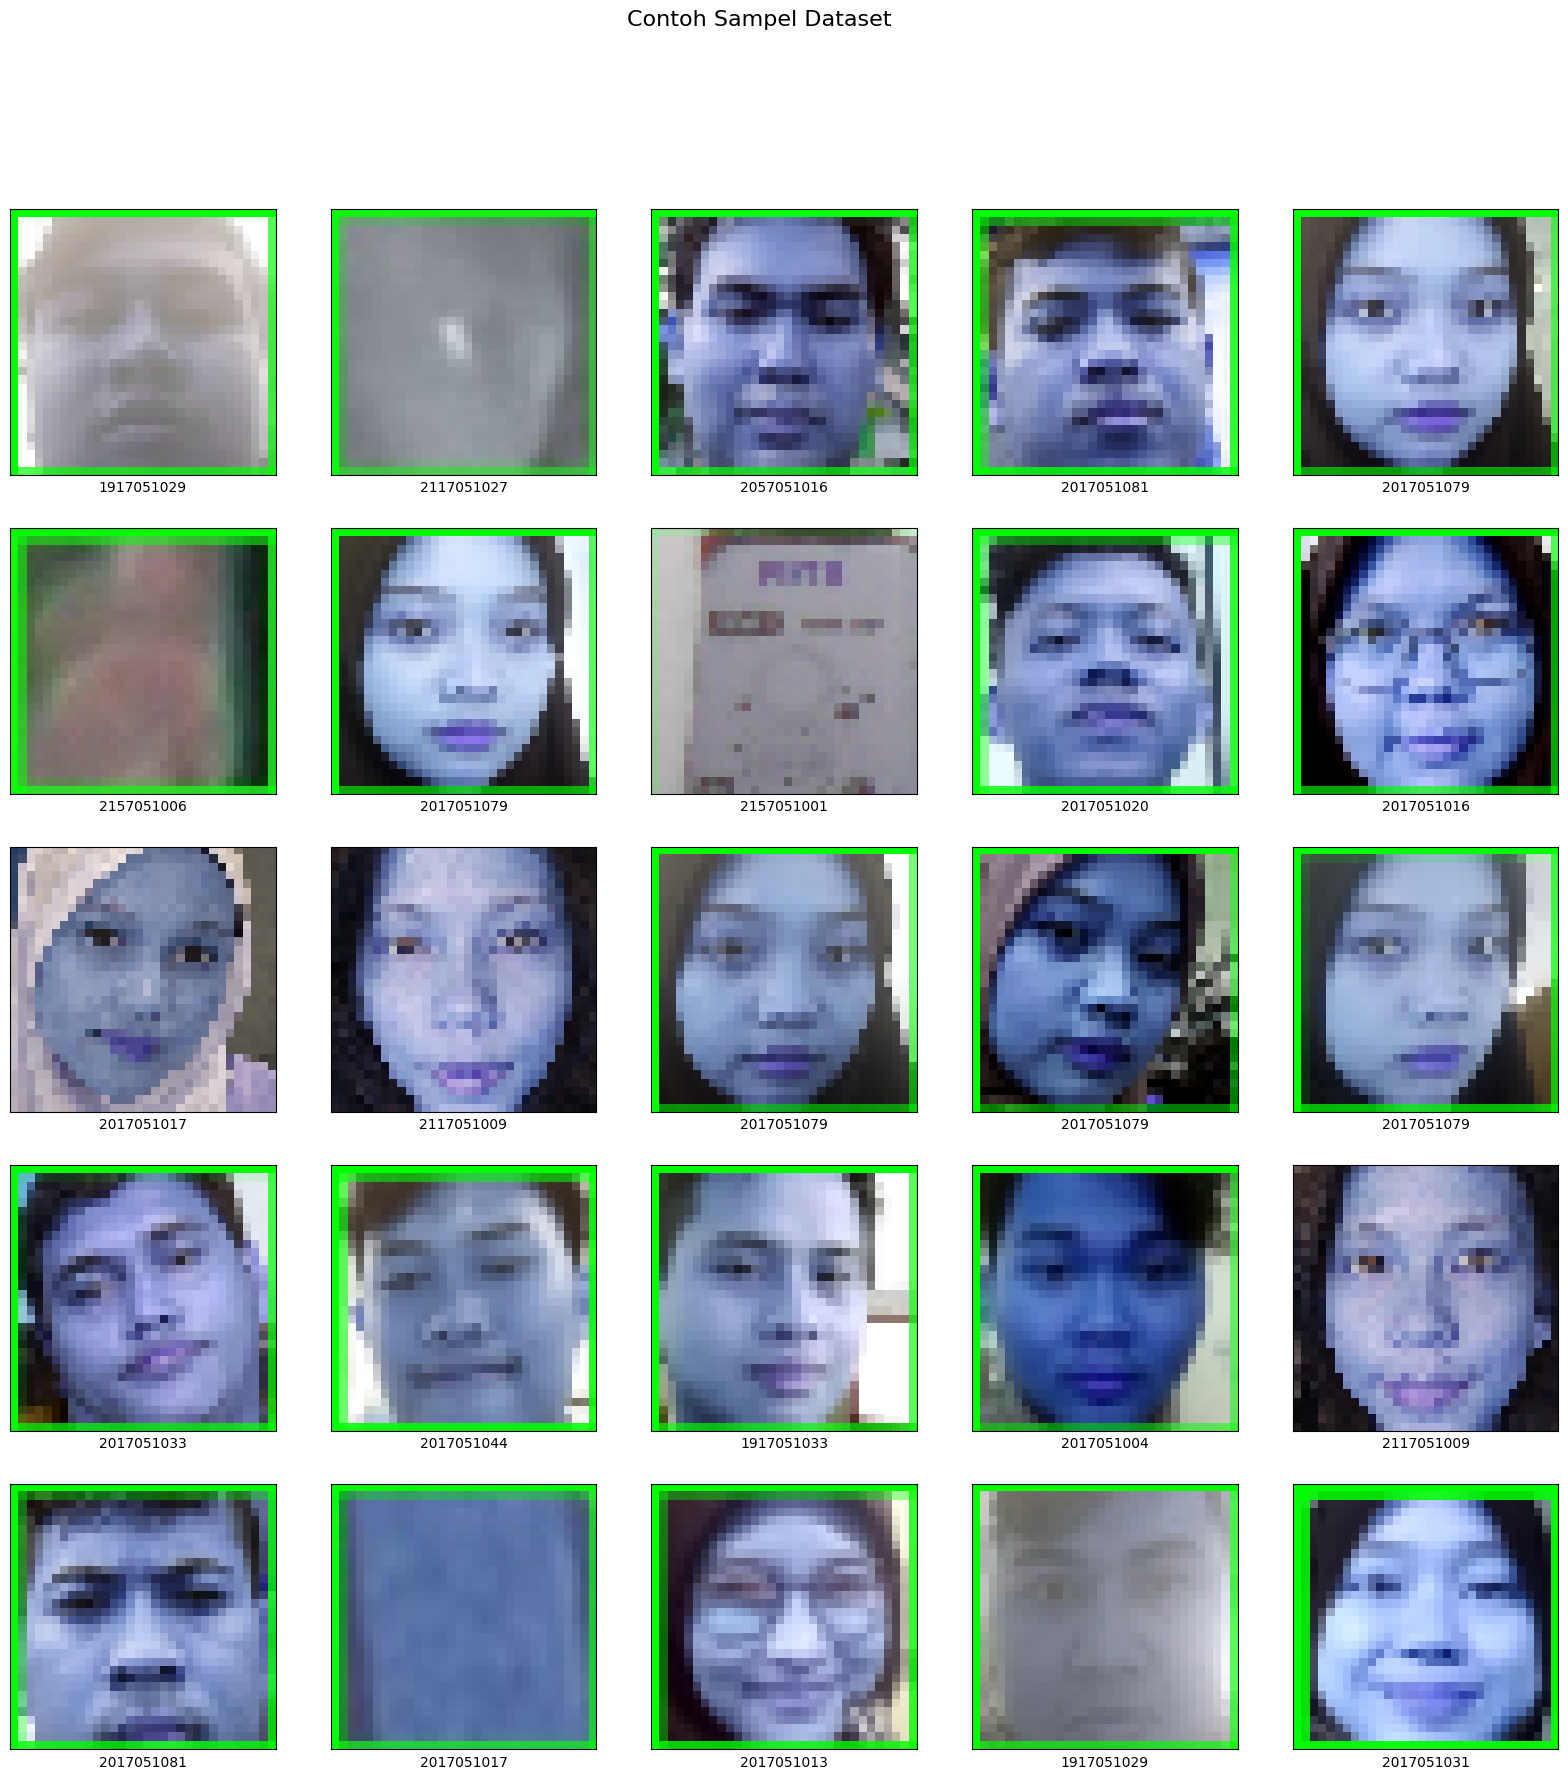

In [38]:
display_examples(class_names, train_images, train_labels)

In [39]:
train_data = ImageDataGenerator(rescale=1/255)
validation_data = ImageDataGenerator(rescale=1/255)

In [40]:
train_dataset = train_data.flow_from_directory(train_dir,
                                               target_size=IMG_SIZE,
                                               batch_size=32,
                                               class_mode='sparse')

validation_dataset = validation_data.flow_from_directory(val_dir,
                                                         target_size=IMG_SIZE,
                                                         batch_size=32,
                                                         class_mode='sparse')

Found 497 images belonging to 25 classes.
Found 497 images belonging to 25 classes.


In [41]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    conv1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_in, (1, 1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3, 3), padding='same', activation='relu')(conv3)
    conv5 = Conv2D(f3_in, (1, 1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5, 5), padding='same', activation='relu')(conv5)
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1, 1), padding='same', activation='relu')(pool)
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [42]:
visible = Input(shape=(*IMG_SIZE, 3))
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
layer = Flatten()(layer)
layer = Dense(128, activation='relu')(layer)
output = Dense(nb_classes, activation='softmax')(layer)

model = Model(inputs=visible, outputs=output)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 32, 32, 96)           384       ['input_3[0][0]']             
                                                                                                  
 conv2d_21 (Conv2D)          (None, 32, 32, 16)           64        ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 3)            0         ['input_3[0][0]']             
 g2D)                                                                                       

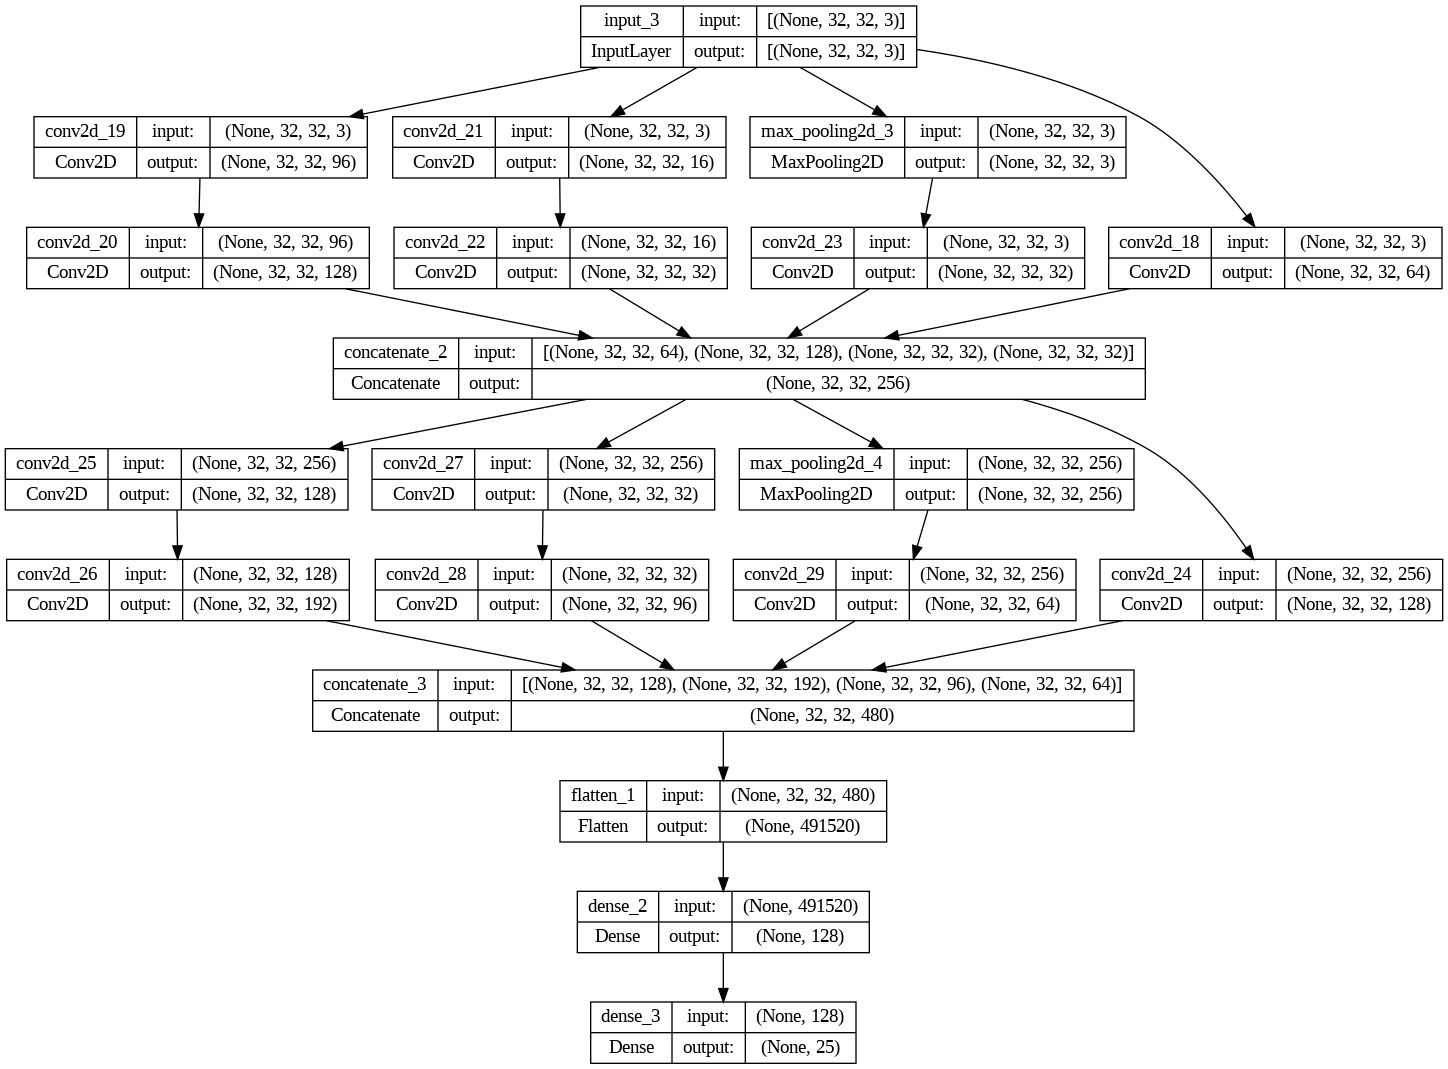

In [43]:
model.summary()
plot_model(model, show_shapes=True, to_file='inception_module.png')

In [44]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
16/16 [==============================] - 77s 5s/step - loss: 8.6639 - accuracy: 0.1087 - val_loss: 2.8915 - val_accuracy: 0.1610
Epoch 2/10
16/16 [==============================] - 80s 5s/step - loss: 2.6452 - accuracy: 0.2475 - val_loss: 2.1494 - val_accuracy: 0.4386
Epoch 3/10
16/16 [==============================] - 80s 5s/step - loss: 2.0001 - accuracy: 0.4688 - val_loss: 1.6387 - val_accuracy: 0.5553
Epoch 4/10
16/16 [==============================] - 73s 5s/step - loss: 1.4602 - accuracy: 0.5855 - val_loss: 1.1763 - val_accuracy: 0.6579
Epoch 5/10
16/16 [==============================] - 73s 5s/step - loss: 1.2215 - accuracy: 0.6519 - val_loss: 0.9579 - val_accuracy: 0.7907
Epoch 6/10
16/16 [==============================] - 80s 5s/step - loss: 0.8956 - accuracy: 0.7686 - val_loss: 0.7344 - val_accuracy: 0.8008
Epoch 7/10
16/16 [==============================] - 72s 5s/step - loss: 0.7033 - accuracy: 0.8068 - val_loss: 0.5486 - val_accuracy: 0.8551
Epoch 8/10
16/16 [==

In [46]:
def plot_accuracy_loss(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Training & Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Training & Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

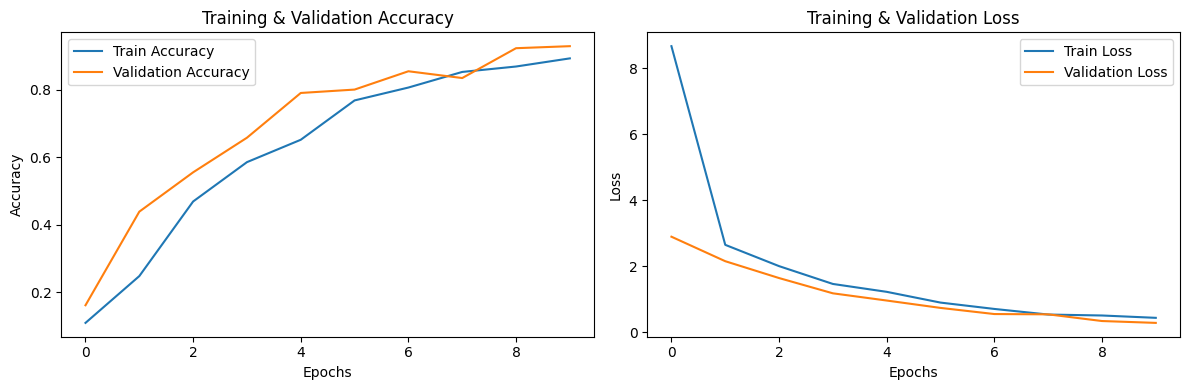

In [47]:
plot_accuracy_loss(history)

In [48]:
# Calculate accuracy on validation data
validation_loss, validation_accuracy = model.evaluate(validation_dataset)

16/16 [==============================] - 13s 829ms/step - loss: 0.2807 - accuracy: 0.9296


In [49]:
print("Validation Accuracy: {:.2f}%".format(validation_accuracy * 100))

Validation Accuracy: 92.96%


In [50]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 32, 32, 96)           384       ['input_3[0][0]']             
                                                                                                  
 conv2d_21 (Conv2D)          (None, 32, 32, 16)           64        ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 3)            0         ['input_3[0][0]']             
 g2D)                                                                                       